# Import Libraries

In [122]:
# Import libraries
import pandas as pd
import numpy as np

#display configurations
pd.options.display.float_format = '{:}'.format
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Graphics libraries
# install
%pip install seaborn
%pip install colorama
# import
import seaborn
import matplotlib.pyplot as plt
from colorama import Fore
from xgboost import plot_importance

#Import model libraries
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor

#future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'

# READ DATA AND RELATIONSHIPS

In [116]:
# Read databases
df_slips_state = pd.read_csv('challenge_annotation.csv', index_col=0)
df_variables = pd.read_csv('challenge_data.csv', index_col=0)

df_slips_state=df_slips_state.rename_axis('timestamp').reset_index()
df_variables=df_variables.rename_axis('timestamp').reset_index()


In [117]:
#FUNCTION TO PREPARE DATA
# function to chunk data to neareast annotation slip

lista_slips = list(df_slips_state[['timestamp','Annotation']].values.T.tolist())

def chunk_states(df,lista):
    table_f=pd.DataFrame(columns=['timestamp','BDEP','TPO','HL','BHT','RPM','TOR','DEPT','WOB','time_to_slip_state','slip_state'])
    
    for states in range(1,len(lista[0])):
        df_tmp = df.loc[(df['timestamp'] >= lista[0][states-1]) & (df['timestamp'] <= lista[0][states])]
        df_tmp['time_to_slip_state'] = lista[0][states-1]
        df_tmp['time_to_slip_state'] = df_tmp['timestamp'] - df_tmp['time_to_slip_state']
        df_tmp['slip_state'] = lista[1][states-1]
        
        table_f=pd.concat([table_f, df_tmp])
        del df_tmp
    return table_f

# DATA PRE-PROCESSING MODELING

In [118]:
# Preparing Data-Model
df_chunk= chunk_states(df_variables,lista_slips)
df_chunk=df_chunk.reset_index(drop=True)

In [119]:
df_chunk.head(10)

,timestamp,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,time_to_slip_state,slip_state
0,1607130862362.0,5042.509,23.51131131829243,492.9859872259483,39.519,0.0,0.0,5795.817,42.9,362.0,off_slips
1,1607130862881.0,5042.509,24.56799946742917,490.61598728735873,39.519,0.0,0.0,5795.817,45.27,881.0,off_slips
2,1607130863389.0,5042.509,26.15303169113428,489.8959873060152,39.519,0.0,0.0,5795.817,45.99,1389.0,off_slips
3,1607130863796.0,5042.509,14.001117976061783,489.71798731062745,39.519,0.0,0.0,5795.817,46.17,1796.0,off_slips
4,1607130864306.0,5042.509,22.190451131871512,491.6359872609289,39.519,0.0,0.0,5795.817,44.25,2306.0,off_slips
5,1607130864814.0,5042.509,22.190451131871512,492.67198723408455,39.519,0.0,0.0,5795.817,43.22,2814.0,off_slips
6,1607130865321.0,5042.509,21.133762982734773,494.8639871772863,39.519,0.0,0.0,5795.817,41.02,3321.0,off_slips
7,1607130865828.0,5042.509,14.001117976061783,496.29398714023273,39.518,0.0,0.0,5795.817,39.59,3828.0,off_slips
8,1607130866338.0,5042.509,20.077074833598036,501.7279869994292,39.518,0.0,0.0,5795.817,34.16,4338.0,off_slips
9,1607130866846.0,5042.509,23.51131131829243,503.1999869612873,39.518,0.0,0.0,5795.817,32.69,4846.0,off_slips


***Data Estatistic Summary Inspection***

In [5]:
#Statistic summary 
df_chunk.describe()

,timestamp,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,time_to_slip_state
count,40153.0,40153.0,40140.0,40151.0,40138.0,40127.0,40136.0,40131.0,40131.0,40153.0
mean,1607140902503.199,4127.823169426942,6.912929424591955,320.9021804722415,20.96596806019234,0.0,0.0,5795.817,110.5510680022925,164660.47226857272
std,5796165.637769724,558.4494067908139,35.68156255179456,157.54589122824387,13.391633160673287,0.0,0.0,0.0,155.60812887135876,258088.07129866708
min,1607130862362.0,3077.832,0.0,80.45599791525702,1.694,0.0,0.0,5795.817,-10.76,3.0
25%,1607135883372.0,3644.582,0.0,97.29399747895766,7.521,0.0,0.0,5795.817,1.7,46644.0
50%,1607140902482.0,4177.561,0.0,393.99398979098856,22.162,0.0,0.0,5795.817,6.47,93891.0
75%,1607145921529.0,4610.241,0.0,444.8889884722181,33.1165,0.0,0.0,5795.817,294.66,172067.0
max,1607150941638.0,5042.746,204.4691568579589,522.0539864727501,39.987,0.0,0.0,5795.817,451.03,1674895.0


In [6]:
#Variables Missing(Nulls) treatment & INSPECTION
#TPO - 0,03% nulls
#HL - 0,004% nulls
#BHT - 0,03% nulls
#RPM - 0,06% nulls & 100% zeros
#TOR - 0,04% nulls & 100% zeros
#DEPT - 0,05% nulls
#WOB - 0,05% nulls 

#Removing nulls, because few nulls observations < 0,1% Total
df_chunk = df_chunk.dropna()
df_chunk.describe()

,timestamp,BDEP,TPO,HL,BHT,RPM,TOR,DEPT,WOB,time_to_slip_state
count,40127.0,40127.0,40127.0,40127.0,40127.0,40127.0,40127.0,40127.0,40127.0,40127.0
mean,1607140904206.8428,4127.664669175369,6.915169015952378,320.8937212437841,20.96262302190545,0.0,0.0,5795.817,110.56182670022677,164551.24913399955
std,5796276.255888463,558.4731877870628,35.68712514058038,157.545287958521,13.391508399271416,0.0,0.0,0.0,155.61215321536858,257904.34024572728
min,1607130862362.0,3077.832,0.0,80.45599791525702,1.694,0.0,0.0,5795.817,-10.76,3.0
25%,1607135885660.0,3644.026,0.0,97.29699747887992,7.52,0.0,0.0,5795.817,1.7,46624.5
50%,1607140904514.0,4177.188,0.0,393.98998979109217,22.157,0.0,0.0,5795.817,6.48,93883.0
75%,1607145923820.0,4610.241,0.0,444.8859884722958,33.1105,0.0,0.0,5795.817,294.66,172058.0
max,1607150941638.0,5042.746,204.4691568579589,522.0539864727501,39.987,0.0,0.0,5795.817,451.03,1674895.0


***CREATE NEW FEATURES IN DATA***

In [7]:
#Variables Missing(Nulls) treatment
#TPO - 0,03% nulls
#HL - 0,004% nulls
#BHT - 0,03% nulls
#RPM - 0,06% nulls & 100% zeros
#TOR - 0,04% nulls & 100% zeros
#DEPT - 0,05% nulls & 100% unique value
#WOB - 0,05% nulls 

#Removing nulls, because few nulls observations < 0,1% Total
df_chunk = df_chunk.dropna()
#Removing columns with unique values
df_chunk = df_chunk.drop(['RPM','TOR','DEPT'], axis=1)

#Create the interaction with variables and time
df_chunk['lnt_BDEP']= df_chunk['BDEP']*np.log(df_chunk['time_to_slip_state'])
df_chunk['lnt_TPO']= df_chunk['TPO']*np.log(df_chunk['time_to_slip_state'])
df_chunk['lnt_HL']= df_chunk['HL']*np.log(df_chunk['time_to_slip_state'])
df_chunk['lnt_BHT']= df_chunk['BHT']*np.log(df_chunk['time_to_slip_state'])
# df_chunk['t_RPM']= df_chunk['RPM']*np.log(df_chunk['time_to_slip_state'])
# df_chunk['t_TOR']= df_chunk['TOR']*np.log(df_chunk['time_to_slip_state'])
# df_chunk['t_DEPT']= df_chunk['DEPT']*np.log(df_chunk['time_to_slip_state'])
df_chunk['lnt_WOB']= df_chunk['WOB']*np.log(df_chunk['time_to_slip_state'])

# Assin binary(0 or 1) to Target Slip
# 0: off_slips , 1: on_slips
conditions = [(df_chunk['slip_state']=='off_slips'), (df_chunk['slip_state']== 'on_slips') ]
choices = [0,1]
df_chunk['target'] = np.select(conditions, choices, default= np.nan)

***EXPLORATORY ANALYSIS***

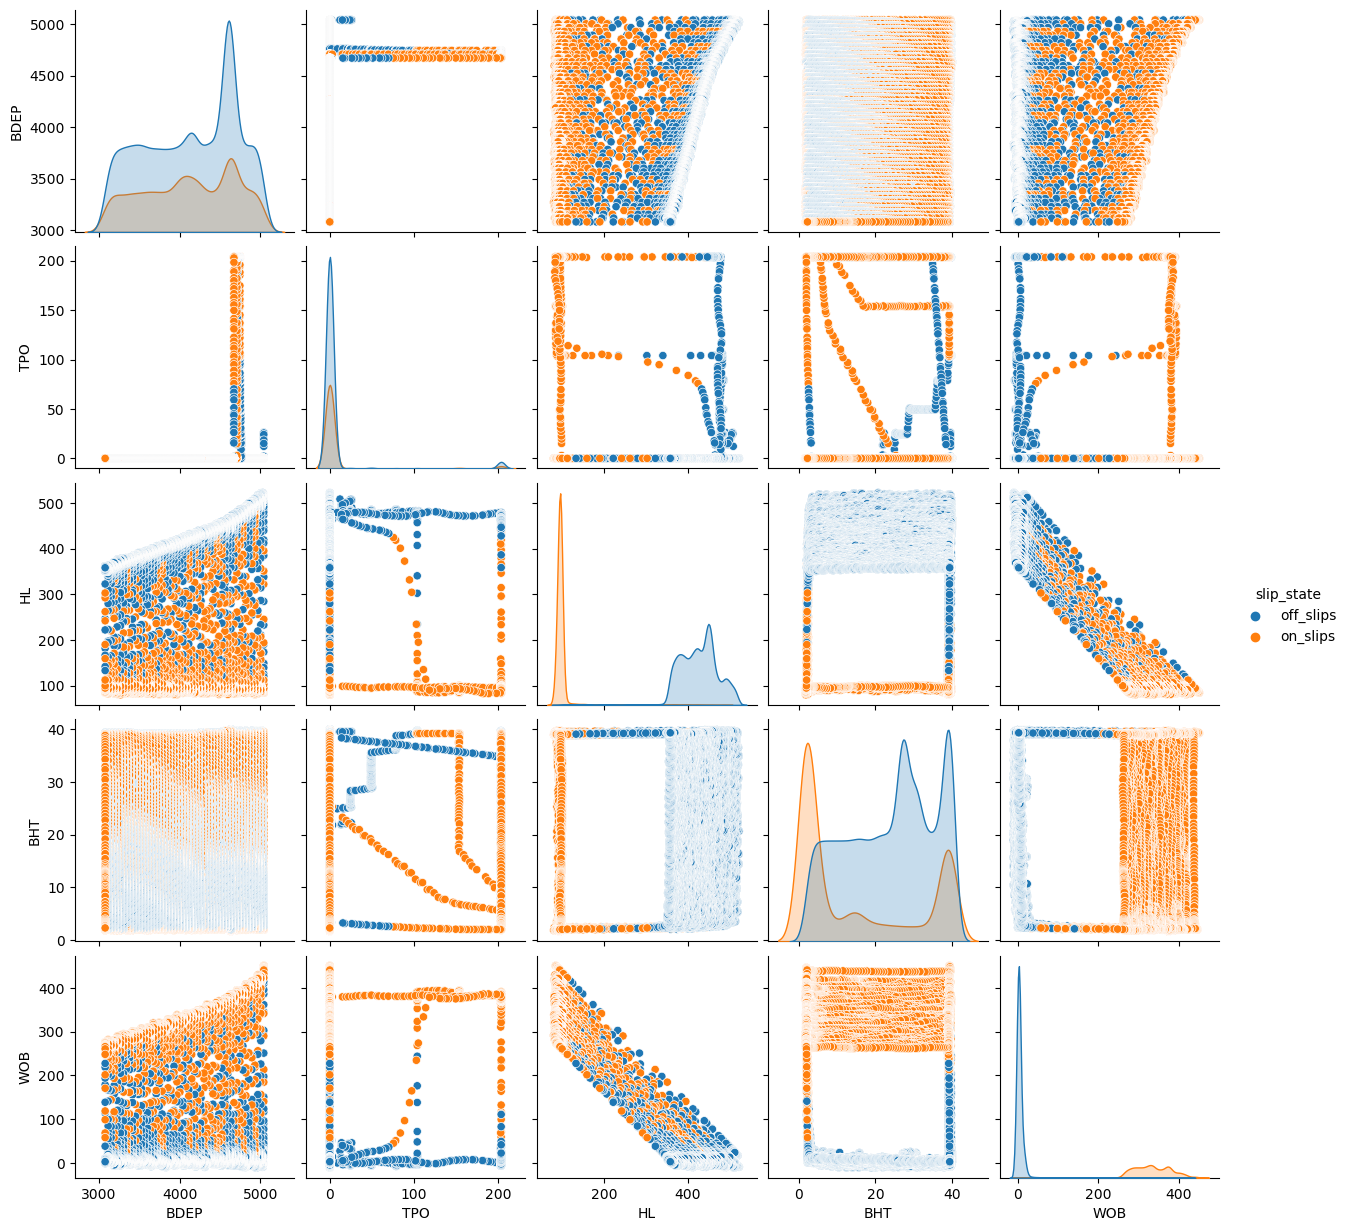

In [8]:
# Exploratory Analysis
seaborn.pairplot(df_chunk[['BDEP','TPO','HL','BHT','WOB','slip_state']], hue ='slip_state')
plt.show()

***CORRELATION ANALYSIS***

In [9]:
#Relations Betweeen Variables
corr= df_chunk[['BDEP','TPO','HL','BHT','WOB','time_to_slip_state']].corr()
corr

,BDEP,TPO,HL,BHT,WOB,time_to_slip_state
BDEP,1.0,0.20182980368652154,0.19620949694055878,0.021216762546765293,0.06791129312357962,0.2336802925267488
TPO,0.20182980368652154,1.0,0.03228486950906866,-0.012479307469771526,0.022882723083099993,-0.054212682545919565
HL,0.19620949694055878,0.03228486950906866,1.0,0.28732638409168965,-0.9640334599162916,0.25794960059989386
BHT,0.021216762546765293,-0.012479307469771526,0.28732638409168965,1.0,-0.2860200548859065,0.25395096387627863
WOB,0.06791129312357962,0.022882723083099993,-0.9640334599162916,-0.2860200548859065,1.0,-0.2080835106950104
time_to_slip_state,0.2336802925267488,-0.054212682545919565,0.25794960059989386,0.25395096387627863,-0.2080835106950104,1.0


# MODELING***
***lINEARITY Bivariate Analysis - Methodoly to quantify relationships between variables vs target***

In [10]:
# sample 70% - 30%
pc_70=int(np.floor(0.7*len(df_chunk)))
df = df_chunk
df_tno = df_chunk.iloc[0:pc_70]
df_oos = df_chunk.iloc[pc_70:len(df_chunk)+1]

***FUNCTION TO GENERATE IV & PSI FOR ALL FEATURES*** 

In [11]:
# FUNCTION TO IV analysis

def iv_continuas(ddf,resposta,lista_continuas, iv_threshold):
    tabla_f=pd.DataFrame(columns=['variavel','iv'])
    for var in lista_continuas:
        _, bins = pd.qcut(ddf[var], q=10, retbins=True, duplicates='drop' )
            
        ddf['decile'] = pd.cut(ddf[var], bins=bins).astype('string')
        #ddf['decile'] = pd.qcut(ddf[var].values, 10, duplicates='drop').astype('string')
        #ddf['decile'] = pd.qcut(ddf[var].values, 10, duplicates='drop').codes + 1
        df2=ddf.groupby(['decile'], dropna=True)[resposta].sum().reset_index(name='default')
        df2_i=ddf.groupby(['decile'], dropna=True)[resposta].count().reset_index(name='total')
        df2= pd.merge(df2,df2_i,on=['decile'],how='left')
        df2['zeros']=df2['total']-df2['default']
        df2['pct_inad']=df2['default']/(df2['default'].sum())
        df2['pct_zeros']=df2['zeros']/(df2['zeros'].sum())
        df2['woe']=np.log(df2['pct_inad']/df2['pct_zeros'])
        df2=df2.loc[df2['woe']>-100]
        df2['iv']=df2['woe']*(df2['pct_inad']-df2['pct_zeros'])
        iv=df2['iv'].sum()
        tabla_f=tabla_f.append({'variavel':var,'iv':iv},ignore_index=True)
        tabla_f=tabla_f.sort_values(by=['iv'], ascending=False)
    return tabla_f[tabla_f['iv']>=iv_threshold]

def tabla_iv_import_continuas(df,df_tno_lab,df_oos_lab,var_resposta, lista_continuas):
        
        tabla_tno_lab=pd.DataFrame()
        tabla_oos_lab= pd.DataFrame()

        for var in lista_continuas:
                  
            # Generate bins from control group
            _, bins = pd.qcut(df[var], q=10, retbins=True, duplicates='drop' )
            
            df_tno_lab['decile'] = pd.cut(df_tno_lab[var], bins=bins).astype('string')
            df_oos_lab['decile'] = pd.cut(df_oos_lab[var], bins=bins).astype('string')

            df_tno_lab['order_decile'] = pd.cut(df_tno_lab[var], bins=bins, labels=False)+1
            df_oos_lab['order_decile'] = pd.cut(df_oos_lab[var], bins=bins, labels=False)+1
            

            
            #ddf['decile'] = pd.qcut(ddf[var].values, 10, duplicates='drop').codes + 1
            # BIVARIADA BASE TREINO - LABORATORIO
            df2 = df_tno_lab.groupby(['decile','order_decile'], dropna=True)[var_resposta].sum().reset_index(name='default').rename(columns={'decile':'categoria','order_decile': 'n_categoria'})
            df2['variavel'] = var
    
            df2_i = df_tno_lab.groupby(['decile','order_decile'], dropna=True)[var_resposta].count().reset_index(name='vol_total').rename(columns={'decile':'categoria','order_decile': 'n_categoria'})
    
            total_rows = df2_i['vol_total'].sum() # sumamos cantidad
            total_defaults = df2['default'].sum() # sumamos los 1s
    
            df2 = pd.merge(df2, df2_i, on=['categoria','n_categoria'], how='left')
            df2['zeros'] = df2['vol_total'] - df2['default']
            df2['pc_inad'] = df2['default'] / (df2['default'].sum() + 0.0001)
            df2['pc_zeros'] = df2['zeros'] / (df2['zeros'].sum() +0.0001)
            df2['risco_relativo'] = df2['pc_inad'] / (df2['pc_zeros'] + 0.0001)
            df2['pc_total'] = df2['vol_total'] / (total_rows + 0.0001)
            df2['taxa_inad'] = df2['default'] / (df2_i['vol_total'] + 0.0001)
            df2['woe'] = np.log(df2['risco_relativo'])
            df2_tmp = df2.loc[df2['woe'] > -100]
    
            df2['iv'] = df2_tmp['woe'] * (df2_tmp['pc_inad'] - df2_tmp['pc_zeros'])
            df2 = df2.sort_values('n_categoria')
            df2['n_categoria']=df2['n_categoria'].astype('string')
            # total|sum categoria
            df3 = pd.DataFrame()
            df3 = df3.append({'variavel': var,
                              'n_categoria': 'total',
                              'categoria': 'total',
                              'vol_total': total_rows,
                              'pc_total': 1,
                              'taxa_inad': total_defaults / (total_rows+0.0001),
                              'woe':  df2_tmp['woe'].sum(),
                              'iv': df2['iv'].sum()
                              }, ignore_index=True)
            #del df2_tmp
    
            df2 = pd.concat([df2, df3], ignore_index = True)
            tabla_tno_lab = pd.concat([tabla_tno_lab, df2], ignore_index = True)
    
            del df2, df3
            
            # BIVARIADA OOS - LABORATORIO
            df2 = df_oos_lab.groupby(['decile'], dropna=True)[var_resposta].sum().reset_index(name='default').rename(columns={'decile':'categoria'})
            df2['variavel'] = var
    
            df2_i = df_oos_lab.groupby(['decile'], dropna=True)[var_resposta].count().reset_index(name='vol_total').rename(columns={'decile':'categoria'})
    
            total_rows = df2_i['vol_total'].sum() # sumamos cantidad
            total_defaults = df2['default'].sum() # sumamos los 1s
    
            df2 = pd.merge(df2, df2_i, on=['categoria'], how='left')
            df2['zeros'] = df2['vol_total'] - df2['default']
            df2['pc_inad'] = df2['default'] / (df2['default'].sum() + 0.0001)
            df2['pc_zeros'] = df2['zeros'] / (df2['zeros'].sum() +0.0001)
            df2['risco_relativo'] = df2['pc_inad'] / (df2['pc_zeros'] + 0.0001)
            df2['woe'] = np.log(df2['risco_relativo'])
            df2['pc_total'] = df2['vol_total'] / (total_rows + 0.0001)
            df2['taxa_inad'] = df2['default'] / (df2_i['vol_total'] + 0.0001)
            df2_tmp1 = df2.loc[df2['woe'] > -100]
    
            df2['iv'] = df2_tmp1['woe'] * (df2_tmp1['pc_inad'] - df2_tmp1['pc_zeros'])
            df2['psi']= (df2_tmp1['pc_total']-df2_tmp['pc_total'])*np.log(df2_tmp1['pc_total']/df2_tmp['pc_total'])
           
    
            # total|sum categoria
            df3 = pd.DataFrame()
            df3 = df3.append({'variavel': var,
                              'categoria': 'total',
                              'vol_total': total_rows,
                              'pc_total': 1,
                              'taxa_inad': total_defaults / (total_rows+0.0001),
                              'woe':  df2_tmp1['woe'].sum(),
                              'iv': df2['iv'].sum(),
                              'psi':df2['psi'].sum(),
                              }, ignore_index=True)
            del df2_tmp1, df2_tmp
    
            df2 = pd.concat([df2, df3], ignore_index = True)
            tabla_oos_lab = pd.concat([tabla_oos_lab, df2], ignore_index = True)
    
            del df2, df3
        return tabla_tno_lab[['variavel','n_categoria', 'categoria', 'vol_total', 'pc_total', 'taxa_inad', 'risco_relativo', 'woe', 'iv']], tabla_oos_lab[['variavel', 'categoria', 'vol_total', 'pc_total', 'taxa_inad', 'risco_relativo', 'woe', 'iv','psi']]

***DEFINE THRESHOLD, TO SELECT RELEVANT FEATURES***

**Inspection the data, we can define a threshold = 0.05**

In [12]:
# THRESHOLD BIVARIATE
var_resposta = 'target'
lista_continuas = ['BDEP','TPO','HL','BHT','WOB','time_to_slip_state','lnt_BDEP','lnt_TPO','lnt_HL','lnt_BHT','lnt_WOB']
iv_threshold=0.0

iv_var_continuas = iv_continuas(df_tno,var_resposta,lista_continuas, iv_threshold)
iv_var_continuas

,variavel,iv
0,HL,inf
1,BHT,inf
2,lnt_HL,10.535685990908425
3,WOB,6.8453614456060015
10,lnt_WOB,6.199118741572469
4,lnt_BHT,1.241249438828105
5,time_to_slip_state,0.7696268473025546
6,lnt_BDEP,0.3750181413176697
7,BDEP,0.060272006723400245
8,TPO,0.0


# TABLE WITH IV & PSI FOR ALL FEATURES

In [13]:
#BIVARIATE BY DECILE
var_resposta = 'target'
lista_continuas = ['BDEP','HL','BHT','WOB','time_to_slip_state','lnt_BDEP','lnt_HL','lnt_BHT','lnt_WOB']
iv_threshold=0.0


table_tno,table_oos = tabla_iv_import_continuas(df,df_tno,df_oos, var_resposta, lista_continuas)

#Rename columns table_tno, table_oos
table_tno=table_tno.drop(['n_categoria'], axis=1)
table_tno.rename({ 'vol_total':'vol_total_TNO', 'pc_total':'pc_total_TNO', 'taxa_inad':'taxa_inad_TNO', 'risco_relativo':'RR_TNO', 'woe':'WOE_TNO', 'iv':'IV_TNO'}, axis=1, inplace=True)
table_oos.rename({ 'vol_total':'vol_total_OOS', 'pc_total':'pc_total_OOS', 'taxa_inad':'taxa_inad_OOS', 'risco_relativo':'RR_OOS', 'woe':'WOE_OOS', 'iv':'IV_OOS','psi':'PSI_OOS'}, axis=1, inplace=True)

table_bivariada = table_tno.merge(table_oos, on=['variavel','categoria'], how='outer').sort_values(by=['variavel','categoria'], ascending=True)
table_bivariada['categoria']=table_bivariada['categoria'].astype('string')

#table_bivariada

In [14]:
table_bivariada.head(11)

,variavel,categoria,vol_total_TNO,pc_total_TNO,taxa_inad_TNO,RR_TNO,WOE_TNO,IV_TNO,vol_total_OOS,pc_total_OOS,taxa_inad_OOS,RR_OOS,WOE_OOS,IV_OOS,PSI_OOS
96,BDEP,"(3077.832, 3305.43]",NaN,NaN,NaN,NaN,NaN,NaN,4116.0,0.3419172591633389,0.3493683102680197,1.1312518716348092,0.12332487051443942,0.005323574866303632,0.1728847275192223
97,BDEP,"(3305.43, 3526.98]",NaN,NaN,NaN,NaN,NaN,NaN,3910.0,0.32480478214981906,0.305370836179774,0.9261629644759694,-0.0767050722649083,0.001877087617673538,0.15023812924896235
98,BDEP,"(3526.98, 3764.154]",NaN,NaN,NaN,NaN,NaN,NaN,4012.0,0.33327795037981434,0.3095712784254417,0.9446201819813014,-0.05697235611073645,0.0010651325743211203,0.1613558598783008
0,BDEP,"(3764.154, 4003.478]",4023.0,0.14322842444022918,0.3077305416920074,0.9412173574516023,-0.06058118046769646,0.0005140403887712272,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BDEP,"(4003.478, 4177.188]",4002.0,0.14248077420079472,0.3858070868114171,1.329904152717439,0.28510687401082463,0.012153754417740461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BDEP,"(4177.188, 4390.424]",4012.0,0.14283679812433495,0.3616649959704637,1.1995719671793008,0.18196479914626282,0.004895682995509667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BDEP,"(4390.424, 4597.744]",4014.0,0.14290800290904299,0.26258096007521275,0.7539819742502657,-0.2823868180898401,0.01075524409873094,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BDEP,"(4597.744, 4635.444]",4696.0,0.16718883449448577,0.3011073189713092,0.9123266214891227,-0.09175721542604509,0.0013752672865968093,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,BDEP,"(4635.444, 4822.101]",3328.0,0.11848476175418413,0.3206129711354275,0.9990550734191262,-0.0009453733054321487,1.1398882329898263e-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,BDEP,"(4822.101, 5042.746]",4013.0,0.14287240051668898,0.30849737581616304,0.9446068009969388,-0.056986521676317854,0.0004536751514295934,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
#Download BIVARIATE TABLE to csv
table_bivariada.mask(table_bivariada.isna(), "null").to_csv('Bivariate.csv', mode = 'w',index=False, header=True )

# TESTING PARAMETRIC & MACHINE LEARNING MODELS
***The goal is to identify whats the best method.***

***Linear or not Linear behaivors***

***SPLIT TRAIN AND TEST SAMPLE***

In [16]:
#AMOSTRAS
df_tno['sample']='train'
df_oos['sample']='valid'
#BASE COMPLETA
df= pd.concat([df_tno, df_oos], ignore_index = True)
# TRAIN MATRIX
Y_treino = df_tno.target
X_treino = df_tno[['HL','lnt_WOB','BHT','time_to_slip_state','BDEP']]

***LOGIT MODEL***

In [17]:
#***PARAMETRIC MODEL***
#LOGIT MODEL
model_logit = sm.Logit(Y_treino, X_treino).fit(method='newton')
#MODEL - SUMMARY
model_logit.summary()

Optimization terminated successfully.
         Current function value: 0.019022
         Iterations 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 target   No. Observations:                28088
Model:                          Logit   Df Residuals:                    28083
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 Sep 2023   Pseudo R-squ.:                  0.9697
Time:                        01:21:52   Log-Likelihood:                -534.30
converged:                       True   LL-Null:                       -17621.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
HL                    -0.0838      0.005    -18.143      0.000      -0.093      -0.075
lnt_WOB               -0.0036      0.000     -9.633      0.000      -0.004      -0.003
BHT                   -0.2163      0.012    -17.311      0.000      -0.241      -0.192
time_to_slip_state  1.536e-06    6.3e-07      2.438      0.015    3.01e-07    2.77e-06
BDEP                   0.0077      0.000     16.607      0.000       0.007       0.009
======================================================================================

Possibly complete quasi-separation: A fraction 0.40 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

***ML XBOOSTING MODEL***

In [19]:
#***ML XBOOSTING MODEL***
Y_treino = df_tno.target
X_treino = df_tno[['HL','WOB','lnt_HL','lnt_WOB','BHT','lnt_BHT','time_to_slip_state','lnt_BDEP','BDEP']]

Y_valid = df_oos.target
X_valid = df_oos[['HL','WOB','lnt_HL','lnt_WOB','BHT','lnt_BHT','time_to_slip_state','lnt_BDEP','BDEP']]


dtrain = xgb.DMatrix(X_treino, label=Y_treino, enable_categorical=True)
dvalid = xgb.DMatrix(X_valid, label=Y_valid, enable_categorical=True)

#XBOOSTING MODEL
# Define hyperparameters
# params = {"objective": "binary:logistic", "tree_method": "gpu_hist"}
# n = 5

# model_xboosting = xgb.cv(
#    params, dtrain,
#    num_boost_round=n,
#    nfold=5,
#    metrics=["mlogloss", "auc", "merror"],
# )

# #MODEL - SUMMARY
# model_xboosting.summary()

 ***RUN JUST 1 TIM, TO DEFINE BEST PARAMETERS TO XBOOSTINGE***

In [35]:
# #First group of parameters
# params = {
#     # parameters to be refined
#     'max_depth':6,
#     'min_child_weight': 1,
#     'eta':.3,
#     'subsample': 1,
#     'colsample_bytree': 1,
#     # type os problem ('binary')
#     'objective':'binary:hinge',
#     # evaluation methos 
#     'eval_metric' : 'auc',
# }


# num_boost_round = 1000
# first_model = xgb.train(
#     params,
#     dtrain,
#     num_boost_round=num_boost_round,
#     evals=[(dvalid, "Test")],
#     early_stopping_rounds=10 
# )

# #CHOOSE THE BEST PARAMETERS
# #REFINE max_depth e min_child_weight
# #lista with all combination max_depth & min_child_weight to test. 
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in range(9,12)
#     for min_child_weight in range(1,10)
# ]
# #define score initial values, to save best AUC score and parameters combination

# max_auc = float(0)
# best_params = None
# for max_depth, min_child_weight in gridsearch_params:
  
#     # reload parameters
#     params['max_depth'] = max_depth
#     params['min_child_weight'] = min_child_weight    
    
#     # Execute function .cv
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round, 
#         seed=42,
#         nfold=5,
#         metrics={'auc'},
#         early_stopping_rounds=100
#     )
    
#     #saving the best AUC in cross validatin
#     mean_auc = cv_results['test-auc-mean'].max()
#     boost_rounds = cv_results['test-auc-mean'].values.argmax()
#     #print("\tAUC {} com {} rounds".format(mean_mae, boost_rounds))
#     if mean_auc > max_auc:
#         max_auc = mean_auc
#         best_params = (max_depth,min_child_weight)
        
# print("Best params: {},{}, auc: {}".format(best_params[0], best_params[1], max_auc))

[0]	Test-auc:0.50000
[1]	Test-auc:0.99956
[2]	Test-auc:0.99761
[3]	Test-auc:0.99956
[4]	Test-auc:0.99956
[5]	Test-auc:0.99974
[6]	Test-auc:0.99839
[7]	Test-auc:0.99858
[8]	Test-auc:0.99839
[9]	Test-auc:0.99974
[10]	Test-auc:0.99846
[11]	Test-auc:0.99974
[12]	Test-auc:0.99974
[13]	Test-auc:0.99974
[14]	Test-auc:0.99974
Best params: 9,7, auc: 0.9998907091106229


In [36]:
# #REFINE "subsample" & "colsample"

# #List with combination of values of parameters
# gridsearch_params = [
#     (subsample, colsample)
#     for subsample in [i/10. for i in range(7,11)]
#     for colsample in [i/10. for i in range(7,11)]
# ]
# max_auc = float(0)
# best_params = None

# #start with the bigger values to smaller values
# for subsample, colsample in reversed(gridsearch_params):
# # Atualizando os parâmetros
#     params['subsample'] = subsample
#     params['colsample_bytree'] = colsample
#     # Executando .cv
#     cv_results = xgb.cv(
#         params,
#         dtrain,
#         num_boost_round=num_boost_round,
#         seed=42,
#         nfold=5,
#         metrics={'auc'},
#         early_stopping_rounds=100
#     )
#     # Pegando o melhor resultado AUC da cross validation
#     mean_auc = cv_results['test-auc-mean'].max()
#     boost_rounds = cv_results['test-auc-mean'].values.argmax()
#     #print("Best params: {}, {}, MAE: {}".format(best_params[0], best_params[1], min_mae))
#     if mean_auc > max_auc:
#         max_auc = mean_auc
#         best_params = (subsample,colsample)
# print("Best params: {}, {}, auc: {}".format(best_params[0], best_params[1], max_auc))


Best params: 0.8, 0.8, auc: 0.9998899013322091


***FINAL PARAMETERS - XBOOSTING***

In [73]:
# FINAL MODEL - BOOSTING
#parâmetros finais
params = {'colsample_bytree': 0.8,
 'eta': 0.005,
 'eval_metric': 'auc',
 'max_depth': 9,
 'min_child_weight': 7,
 'objective': 'binary:hinge',
 'subsample': 0.8}

num_boost_round = 218
best_model_xboosting = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dvalid, "Test")]
)

[0]	Test-auc:0.50000
[1]	Test-auc:0.50000
[2]	Test-auc:0.50000
[3]	Test-auc:0.50000
[4]	Test-auc:0.50000
[5]	Test-auc:0.50000
[6]	Test-auc:0.50000
[7]	Test-auc:0.50000
[8]	Test-auc:0.50000
[9]	Test-auc:0.50000
[10]	Test-auc:0.50000
[11]	Test-auc:0.50000
[12]	Test-auc:0.50000
[13]	Test-auc:0.50000
[14]	Test-auc:0.50000
[15]	Test-auc:0.50000
[16]	Test-auc:0.50000
[17]	Test-auc:0.50000
[18]	Test-auc:0.50000
[19]	Test-auc:0.50000
[20]	Test-auc:0.50000
[21]	Test-auc:0.50000
[22]	Test-auc:0.50000
[23]	Test-auc:0.50000
[24]	Test-auc:0.50000
[25]	Test-auc:0.50000
[26]	Test-auc:0.50000
[27]	Test-auc:0.50000
[28]	Test-auc:0.50000
[29]	Test-auc:0.50000
[30]	Test-auc:0.50000
[31]	Test-auc:0.50000
[32]	Test-auc:0.50000
[33]	Test-auc:0.50000
[34]	Test-auc:0.50000
[35]	Test-auc:0.50000
[36]	Test-auc:0.50000
[37]	Test-auc:0.50000
[38]	Test-auc:0.50000
[39]	Test-auc:0.50000
[40]	Test-auc:0.50000
[41]	Test-auc:0.50000
[42]	Test-auc:0.50000
[43]	Test-auc:0.50000
[44]	Test-auc:0.50000
[45]	Test-auc:0.5000

# PREDICTIONS LOGIT VS XBOOSTING

In [108]:


# PARAMETRIC PREDICT
# PREDICT MODEL_LOGIT IN DATA
df['prob_logit'] = model_logit.predict(df[['HL','lnt_WOB','BHT','time_to_slip_state','BDEP']])

# PREDICT MODEL_XBOOSTING IN DATA
df['predict_xboosting']= best_model_xboosting.predict(xgb.DMatrix(df[['HL','WOB','lnt_HL','lnt_WOB','BHT','lnt_BHT','time_to_slip_state','lnt_BDEP','BDEP']]))


# CALCULATING EFFICIENCY
***Area under the Curve - AUC*** 

***kolmogorov smirnov - test (ks)***

***ARE THE USUALLY TESTS TO MEASURE EFFICIENCY***

In [46]:
# FUNCTION CALCULATE KS

def ks(data=None,target=None, prob=None):
    data['target0'] = 1 - data[target]
    data['bucket'] = pd.qcut(data[prob], 10)
    grouped = data.groupby('bucket', as_index = False)
    kstable = pd.DataFrame()
    kstable['min_prob'] = grouped.min()[prob]
    kstable['max_prob'] = grouped.max()[prob]
    kstable['events']   = grouped.sum()[target]
    kstable['nonevents'] = grouped.sum()['target0']
    kstable = kstable.sort_values(by="min_prob", ascending=False).reset_index(drop = True)
    kstable['event_rate'] = (kstable.events / data[target].sum()).apply('{0:.2%}'.format)
    kstable['nonevent_rate'] = (kstable.nonevents / data['target0'].sum()).apply('{0:.2%}'.format)
    kstable['cum_eventrate']=(kstable.events / data[target].sum()).cumsum()
    kstable['cum_noneventrate']=(kstable.nonevents / data['target0'].sum()).cumsum()
    kstable['KS'] = np.round(kstable['cum_eventrate']-kstable['cum_noneventrate'], 3) * 100

    #Formating
    kstable['cum_eventrate']= kstable['cum_eventrate'].apply('{0:.2%}'.format)
    kstable['cum_noneventrate']= kstable['cum_noneventrate'].apply('{0:.2%}'.format)
    kstable.index = range(1,11)
    kstable.index.rename('Decile', inplace=True)
    pd.set_option('display.max_columns', 9)
    #print(kstable)
    
    #Display KS
    
    from colorama import Fore
    # print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))
    # return(kstable)
    return print(Fore.RED + "KS is " + str(max(kstable['KS']))+"%"+ " at decile " + str((kstable.index[kstable['KS']==max(kstable['KS'])][0])))

***PARAMETRIC LOGIT EFICCIENCY***

In [47]:
#KS - TRAIN
train_ks = ks(data=df.loc[df['sample']=='train'],target="target", prob="prob_logit")
train_ks

KS is 93.30000000000001% at decile 3


In [93]:
#AUC - TRAIN
print(Fore.RED +"AUC-train:{}".format(roc_auc_score(df['target'].loc[df['sample']=='train'],df['prob_logit'].loc[df['sample']=='train'] )))

AUC-train:0.9994849885563487


In [48]:
#KS - VALID
train_ks = ks(data=df.loc[df['sample']=='valid'],target="target", prob="prob_logit")
train_ks

KS is 92.7% at decile 3


In [112]:
#AUC - VALID
print(Fore.RED +"AUC - valid:{}".format(roc_auc_score(df['target'].loc[df['sample']=='valid'],df['prob_logit'].loc[df['sample']=='valid'] )))

AUC - valid:0.9993933523251244


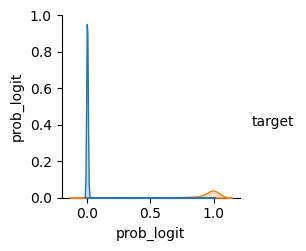

In [113]:
# DIFFERENCE OF DISTRIBUTION
df_prob= df.loc[df['sample']=='valid']
df_prob_plot= df_prob[['prob_logit','target']]
seaborn.pairplot(df_prob_plot, hue ='target')
plt.show()

***MACHINE LEARNING - XBOOSTING EFICCIENCY***

In [97]:
#AUC - TRAIN XBOOSTING
print(Fore.RED +"AUC-train:{}".format(roc_auc_score(df['target'].loc[df['sample']=='train'],df['predict_xboosting'].loc[df['sample']=='train'] )))

AUC-train:0.9998689864794047


In [110]:
#AUC - VALID XBOOSTING
print(Fore.RED +"AUC-valid:{}".format(roc_auc_score(df['target'].loc[df['sample']=='valid'],df['predict_xboosting'].loc[df['sample']=='valid'] )))

AUC-valid:1.0


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

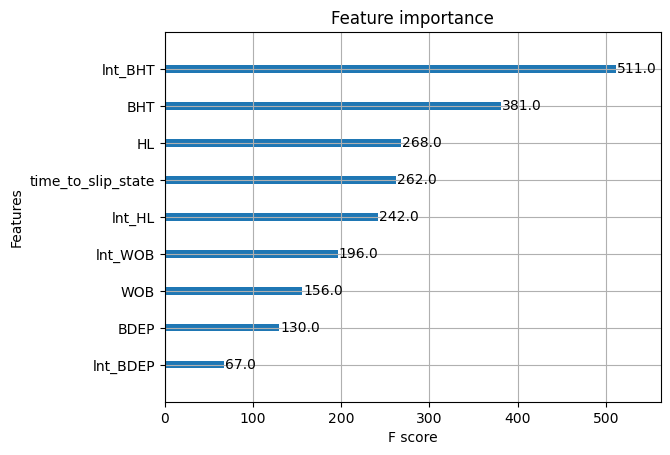

In [111]:
#FEATURE IMPORTANCE
plot_importance(best_model_xboosting, )